In [11]:
import numpy as np
import pandas as pd
from scipy.stats import ttest_1samp 
import matplotlib.pyplot as plt
import seaborn as sns
import os, wget, shutil

# Notebook overview

## Differential Privacy
This project demonstrates how Differential Privacy (DP) can be applied to a data and how an attacker could still infer individual information. This example revolves around anonymizing a dataset of individual heights that contains a significant outlier. In this small example we use a person's height which differs unbelievely from others, however in real-world example, an individulas can have a specific sign that stands out from others. 

## The goal

We want to:

- Protect people's data using Differential Privacy.
- Show how an attacker could still infer private information, especially when someone stands out (like the outlier).

Down below we usecase-2.1 individual's height.

In [12]:
os.makedirs("data", exist_ok=True)
link_original = "https://s3.amazonaws.com/openneuro.org/ds004148/participants.tsv?versionId=wt81Mu2B3fdeiXSis5ym288A64lXRXkR"
wget.download(link_original)
filename = "participants.tsv"
file_ = [os.path.join(root, file) for root, _, files in os.walk(os.getcwd()) for file in files if file == filename]
shutil.copy2(file_[0], "data")
os.remove(file_[0])
print(f"\nOriginal file downloaded.")

100% [..........................................................] 39886 / 39886
Original file downloaded.


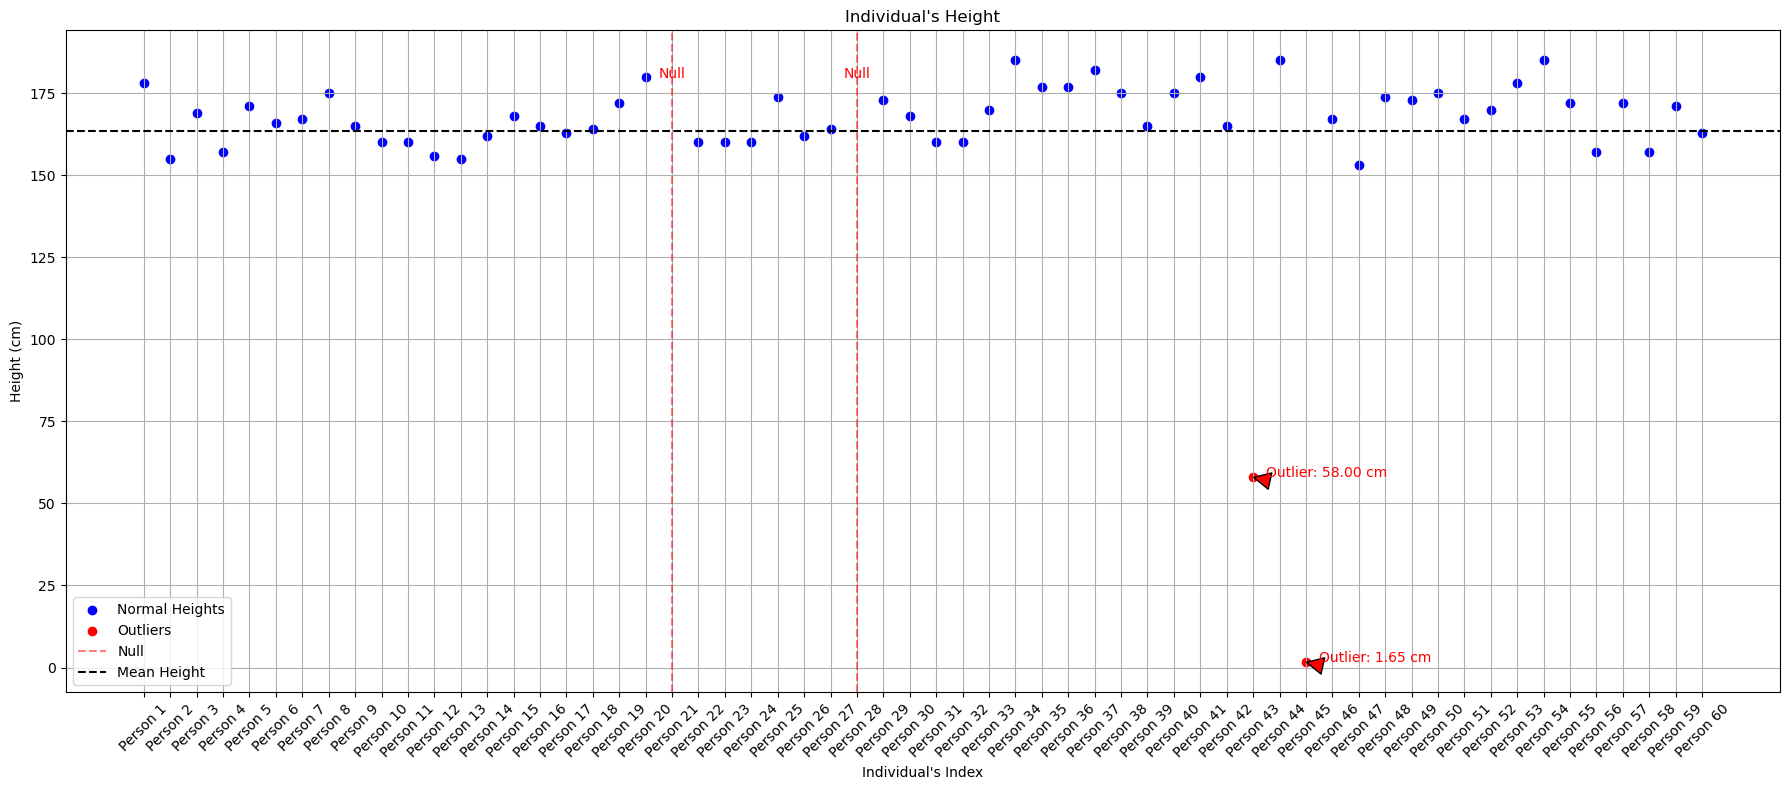

In [66]:
clean_data = data[~np.isnan(data)]
q1 = np.percentile(clean_data, 25)
q3 = np.percentile(clean_data, 75)
iqr = q3 - q1
lower_bound = q1 - 1.5*iqr
upper_bound = q3 + 1.5*iqr

outlier_indices = np.where((data < lower_bound) | (data > upper_bound))[0]
null_indices = np.where(np.isnan(data))[0]

plt.figure(figsize=(18, 8))

normal_indices = [i for i in range(len(data)) if i not in outlier_indices and i not in null_indices]
plt.scatter(normal_indices, data[normal_indices], color='blue', label='Normal Heights')
plt.scatter(outlier_indices, data[outlier_indices], color='red', label='Outliers')

for null_idx in null_indices:
    plt.axvline(x=null_idx, color='red', linestyle='--', alpha=0.5, label='Null' if null_idx == null_indices[0] else "")

for outlier_idx in outlier_indices:
    plt.annotate(f'Outlier: {data[outlier_idx][0]:.2f} cm', 
                xy=(outlier_idx, data[outlier_idx]),
                xytext=(outlier_idx+0.5, data[outlier_idx]),
                arrowprops=dict(facecolor='red', shrink=0.05),
                color='red')

for null_idx in null_indices:
    plt.annotate('Null', 
                xy=(null_idx, np.nanmean(data)), 
                xytext=(null_idx, np.nanmean(data)*1.1),
                ha='center',
                color='red')

plt.axhline(np.nanmean(data), color='black', linestyle='--', label='Mean Height')
plt.title("Individual's Height")
plt.xlabel("Individual's Index")
plt.xticks(range(len(data)), [f"Person {i + 1}" for i in range(len(data))], rotation=45)
plt.ylabel("Height (cm)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## Leave-One-Out (LOO) Estimation

The LOO method computes the mean of the dataset each time one participant is removed. This reveals how much influence each individual has on the mean, particularly sensitive in datasets with outliers.

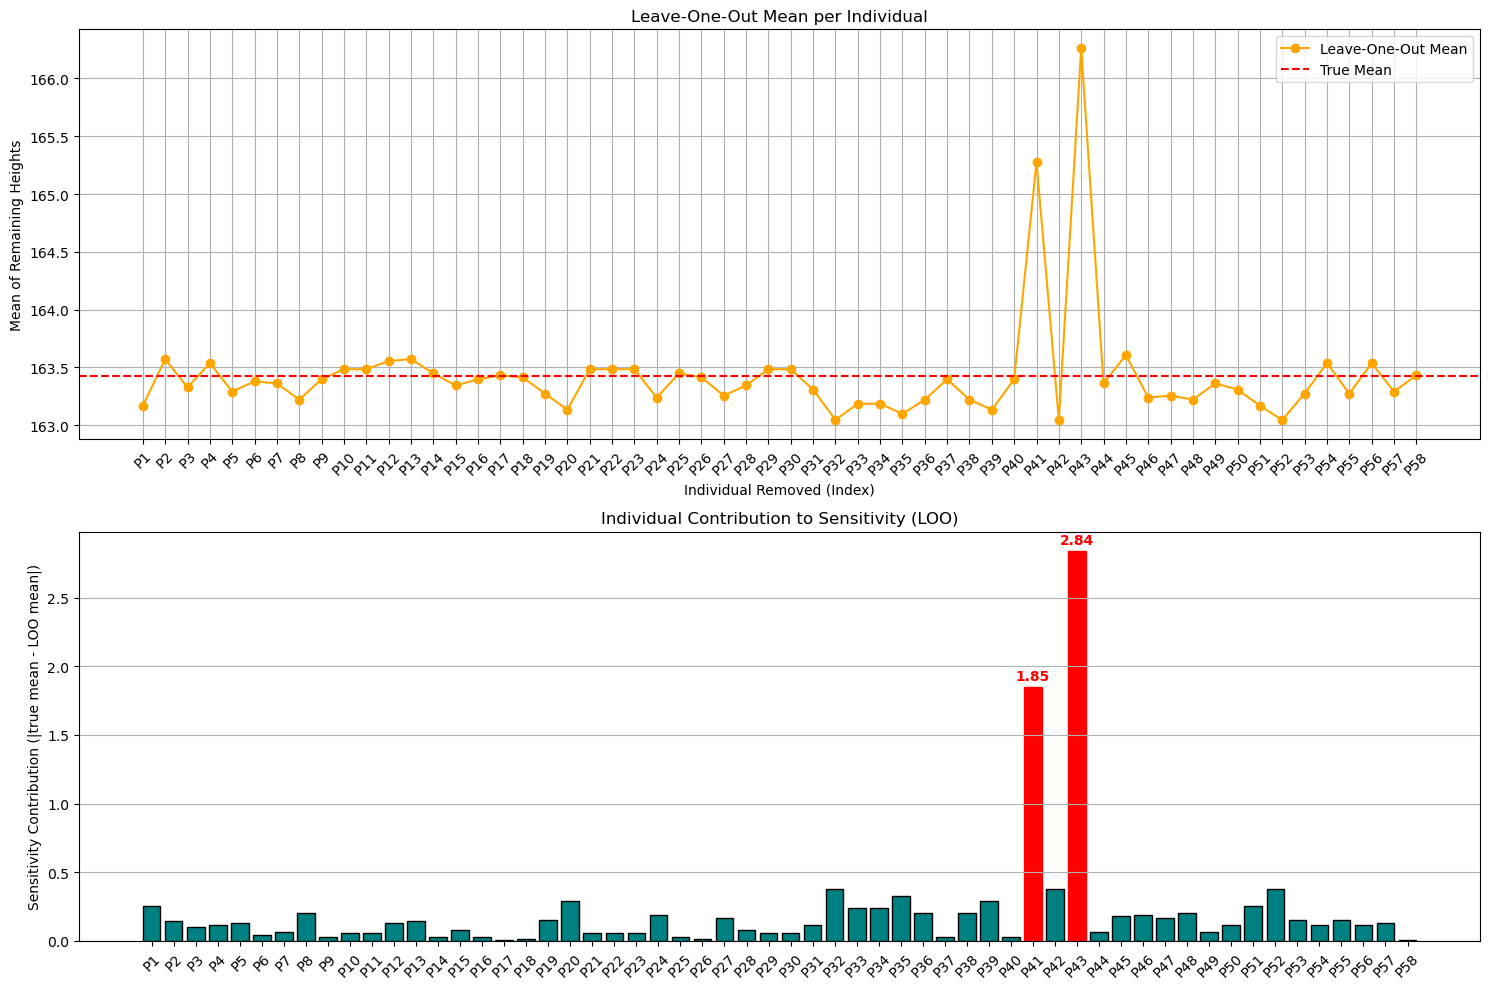

In [67]:
aprx_est = np.array([np.mean(np.delete(clean_data, i)) for i in range(clean_data.shape[0])]).reshape(-1, 1)
n = len(clean_data)
true_mean = np.mean(clean_data)
loo_means = np.array([np.mean(np.delete(clean_data, i)) for i in range(n)])

sensitivity = np.abs(true_mean - loo_means)
fig, axes = plt.subplots(2, 1, figsize=(15, 10))

axes[0].plot(range(len(aprx_est)), aprx_est, marker='o', color='orange', label='Leave-One-Out Mean')
axes[0].axhline(true_mean, color='red', linestyle='--', label='True Mean')
axes[0].set_title("Leave-One-Out Mean per Individual")
axes[0].set_xlabel("Individual Removed (Index)")
axes[0].set_xticks(range(n))
axes[0].set_xticklabels([f"P{i + 1}" for i in range(n)], rotation=45)
axes[0].set_ylabel("Mean of Remaining Heights")
axes[0].legend()
axes[0].grid(True)

bars = axes[1].bar(range(n), sensitivity, color='teal', edgecolor='black')
axes[1].set_xticks(range(n))
axes[1].set_xticklabels([f"P{i + 1}" for i in range(n)], rotation=45)
axes[1].set_ylabel("Sensitivity Contribution (|true mean - LOO mean|)")
axes[1].set_title("Individual Contribution to Sensitivity (LOO)")
axes[1].grid(axis='y')

top_two_indices = np.argsort(sensitivity)[-2:]  
for idx in top_two_indices:
    bars[idx].set_color('red')  
    axes[1].annotate(
        f"{sensitivity[idx]:.2f}", 
        xy=(idx, sensitivity[idx]), 
        xytext=(0, 5),  
        textcoords="offset points",
        ha='center',  
        color='red',  
        weight='bold'  
    )

plt.tight_layout()
plt.show()

## Observation:

One individual (with height 3.0 meters) causes a significant drop in the mean when removed, clearly indicating it's an outlier or someone that differs from others in height. An attacker could identify this participant due to their disproportionate influence on the aggregate statistic.

# Data Leakage
LOO means are vulnerable in non-private settings because they provide overlapping views of the dataset. When the group size is small like here we have 5 people only, the LOO means can be inverted to reveal the original values exactly. An attacker can compute the sum of the remaining 4 values for each LOO mean and achieve the original data by solving a linear equation. 

Here we show how LOO means can be used to reconstruct the original values by solving a linear equations.
This is the height of individuals which attacker does not have access.

$$ [1.73, 1.8, 1.85, 1.79, 3.0] $$

Assuming a study has published their result in form of LOO mean

$$ [2.11, 2.093, 2.08, 2.095 , 1.79]$$ 


### DP as solution

If the data publisher add noise to the LOO means before releasing the result. For example, by adding Laplace noise proportional to the L1 sensitivity of the mean. The attacker cannot recover the true values exactly, because the values are altered with noise. 

We implement a basic DP mechanism by adding Laplace noise scaled by sensitivity, defined here as the maximum deviation between the true mean and the leave-one-out estimates.

Below we show the whole process.

Original data - average: 163.42, std: 27.03 
Reconstructed - average: 166.29, std: 27.51 
Reconstructed from noisy LOO - average: 166.23, std: 27.51 


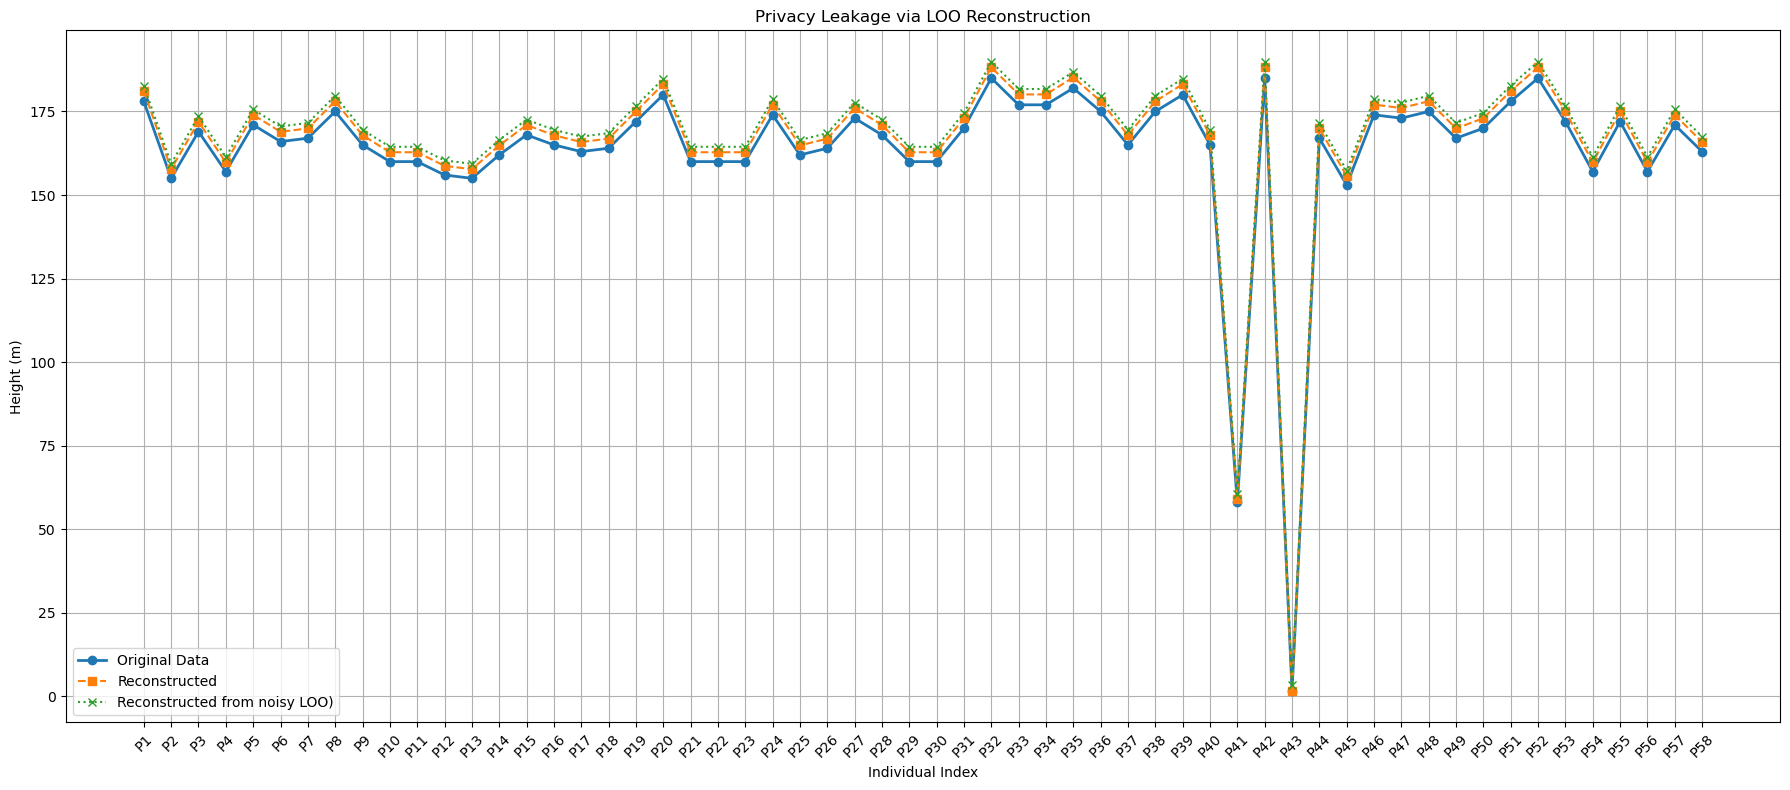

In [82]:
reconstructed = np.linalg.solve(np.ones((n, n)) - np.eye(n), int(clean_data.shape[0]) * loo_means)
print(f"Original data - average: {np.round(clean_data.mean(), 2)}, std: {np.round(clean_data.std(), 2)} ")
print(f"Reconstructed - average: {np.round(reconstructed.mean(), 2)}, std: {np.round(reconstructed.std(), 2)} ")

def dp(loo_mean):
    all_noise = np.full(loo_mean.shape[1], np.nan)

    for p_loo_mean in range(loo_mean.shape[1]):
        loo_estimate = loo_mean[:, p_loo_mean]
        true_mean = np.mean(loo_estimate)
        sensitivity = np.max(np.abs(true_mean - loo_estimate)) 
        noise = np.random.laplace(loc=0.0, scale=sensitivity)
        all_noise[p_loo_mean] = noise
    
    return all_noise
noise = dp(aprx_est)
noisy_mean = aprx_est.flatten() + 1 * noise.flatten()
reconstructed_noisy = np.linalg.solve(np.ones((n, n)) - np.eye(n), int(clean_data.shape[0]) * noisy_mean)
print(f"Reconstructed from noisy LOO - average: {np.round(reconstructed_noisy.mean(), 2)}, std: {np.round(reconstructed_noisy.std(), 2)} ")

indices = np.arange(len(clean_data))

plt.figure(figsize=(18, 8))
plt.plot(indices, clean_data, marker='o', label='Original Data', linewidth=2)
plt.plot(indices, np.linalg.solve(np.ones((n, n)) - np.eye(n), int(clean_data.shape[0]) * loo_means), marker='s', label='Reconstructed', linestyle='--')
plt.plot(indices, np.linalg.solve(np.ones((n, n)) - np.eye(n), int(clean_data.shape[0]) * noisy_loo), marker='x', label='Reconstructed from noisy LOO)', linestyle='dotted')

plt.title("Privacy Leakage via LOO Reconstruction")
plt.xlabel("Individual Index")
plt.ylabel("Height (m)")
plt.xticks(indices, [f"P{i + 1}" for i in indices], rotation=45)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

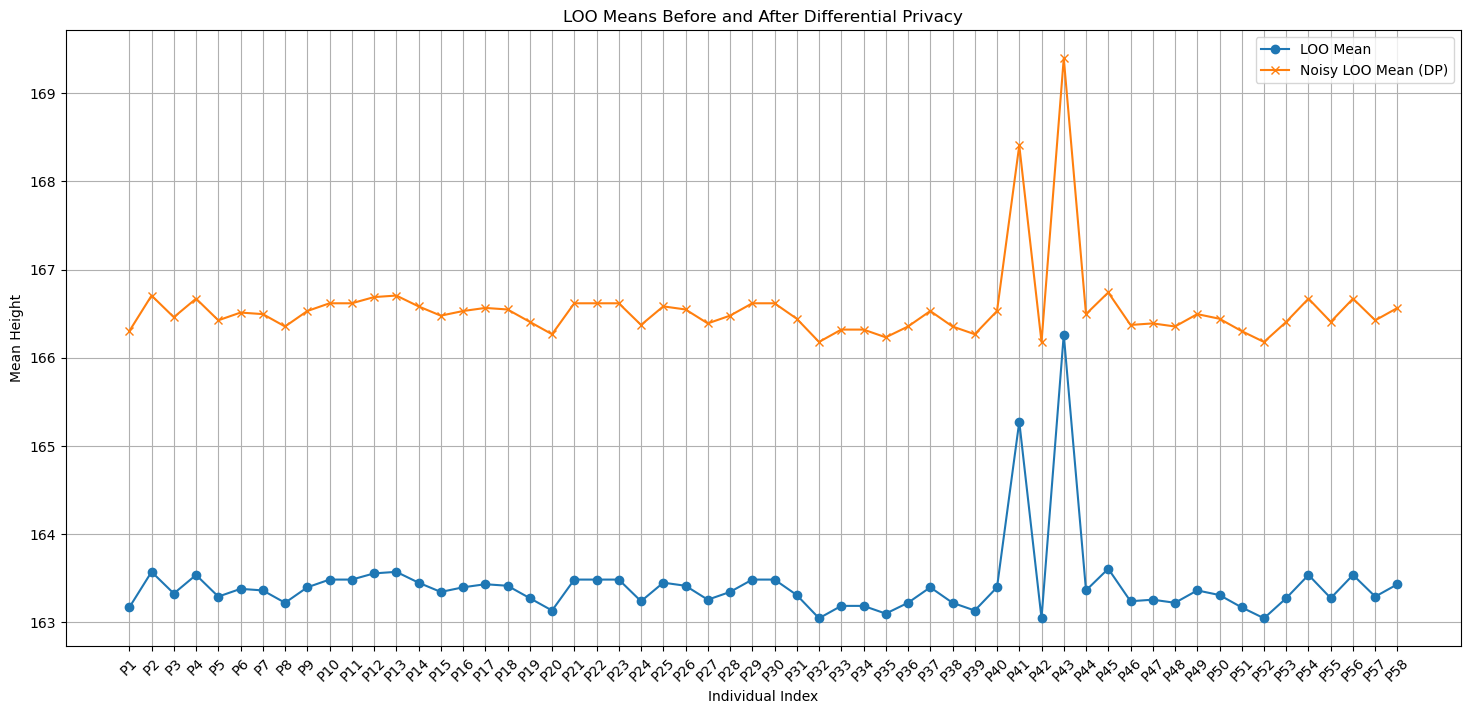

In [85]:
noise = dp(aprx_est)
noisy_mean = aprx_est.flatten() + 1 * noise.flatten()
plt.figure(figsize=(18, 8))
plt.plot(aprx_est.flatten(), label='LOO Mean', marker='o')
plt.plot(noisy_mean, label='Noisy LOO Mean (DP)', marker='x')
plt.title("LOO Means Before and After Differential Privacy")
plt.xlabel("Individual Index")
indices = np.arange(len(clean_data))
plt.xticks(indices, [f"P{i + 1}" for i in indices], rotation=45)
plt.ylabel("Mean Height")
plt.legend()
plt.grid(True)
plt.show()


In [86]:
noise = dp(aprx_est)
print(f"Noise: {noise}")
noisy_mean = aprx_est + 1 * noise 
print(f"LOO mean: {aprx_est.flatten()}")
print(f"Noisy mean: {noisy_mean.flatten()}")
print(f"Found subject index:", np.argmin(np.abs(noisy_mean.flatten())))

Noise: [2.13238331]
LOO mean: [163.16929825 163.57280702 163.32719298 163.5377193  163.29210526
 163.37982456 163.3622807  163.22192982 163.39736842 163.48508772
 163.48508772 163.55526316 163.57280702 163.45       163.34473684
 163.39736842 163.43245614 163.41491228 163.2745614  163.13421053
 163.48508772 163.48508772 163.48508772 163.23947368 163.45
 163.41491228 163.25701754 163.34473684 163.48508772 163.48508772
 163.30964912 163.04649123 163.18684211 163.18684211 163.09912281
 163.22192982 163.39736842 163.22192982 163.13421053 163.39736842
 165.2745614  163.04649123 166.26315789 163.3622807  163.60789474
 163.23947368 163.25701754 163.22192982 163.3622807  163.30964912
 163.16929825 163.04649123 163.2745614  163.5377193  163.2745614
 163.5377193  163.29210526 163.43245614]
Noisy mean: [165.30168155 165.70519032 165.45957629 165.67010261 165.42448857
 165.51220787 165.49466401 165.35431313 165.52975173 165.61747103
 165.61747103 165.68764647 165.70519032 165.58238331 165.47712015


## Simulation
Here we simulate a potential privacy attack scenario where an adversary attempts to reconstruct the original individual data values from noisy LOO means.

To protect privacy, Laplace noise is added to the LOO means using the DP mechanism. However, even after adding noise, it's important to evaluate how well the attacker could still reconstruct the original values. 

The DP mechanism is randomized, each execution adds different noise. So, we run a Monte Carlo (MC) simulation 1000 times to:

- Simulate many possible outcomes of the noisy LOO release.
- Perform reconstruction attempts based on each noisy release.
- Visualize the distribution of attacker guesses for each individual’s value.

This allows us to:

- Understand the variability in the reconstructions.
- Check whether the true values are consistently hidden within a wide distribution.
- Provide empirical evidence that the data remains private on average, even if some reconstructions appear close by chance.

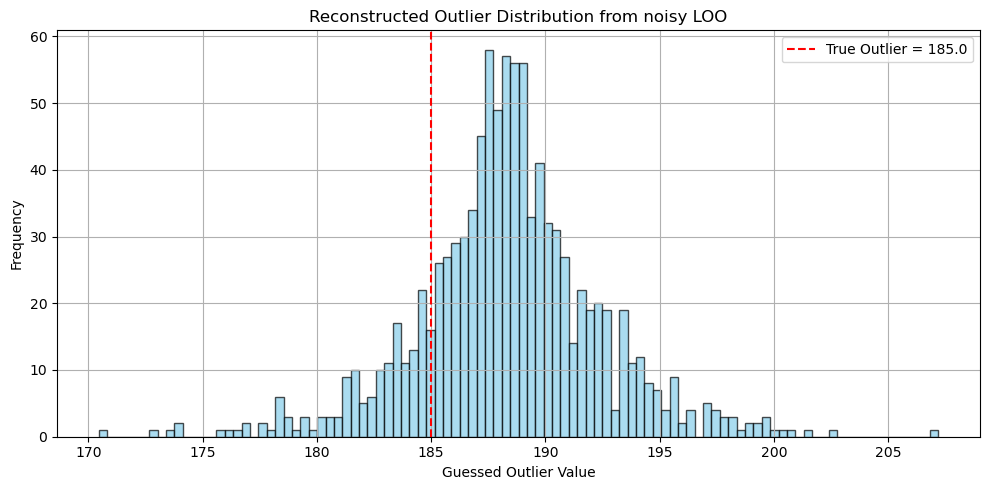

In [92]:
outlier_index = np.argmin(np.abs(noisy_mean.flatten()))
MC = 1000
rec = np.zeros((MC, n))  

for i in range(MC):
    noise = dp(aprx_est)
    noisy_loo = aprx_est.flatten() + 1 * noise.flatten()
    rec[i] = np.linalg.solve(np.ones((n, n)) - np.eye(n), 58 * noisy_loo)

plt.figure(figsize=(10, 5))
plt.hist(rec[:, outlier_index], bins=100, color='skyblue', alpha=0.7, edgecolor='black')
plt.axvline(clean_data[outlier_index], color='red', linestyle='--', label=f"True Outlier = {clean_data[outlier_index]}")
plt.title("Reconstructed Outlier Distribution from noisy LOO")
plt.xlabel("Guessed Outlier Value")
plt.ylabel("Frequency")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


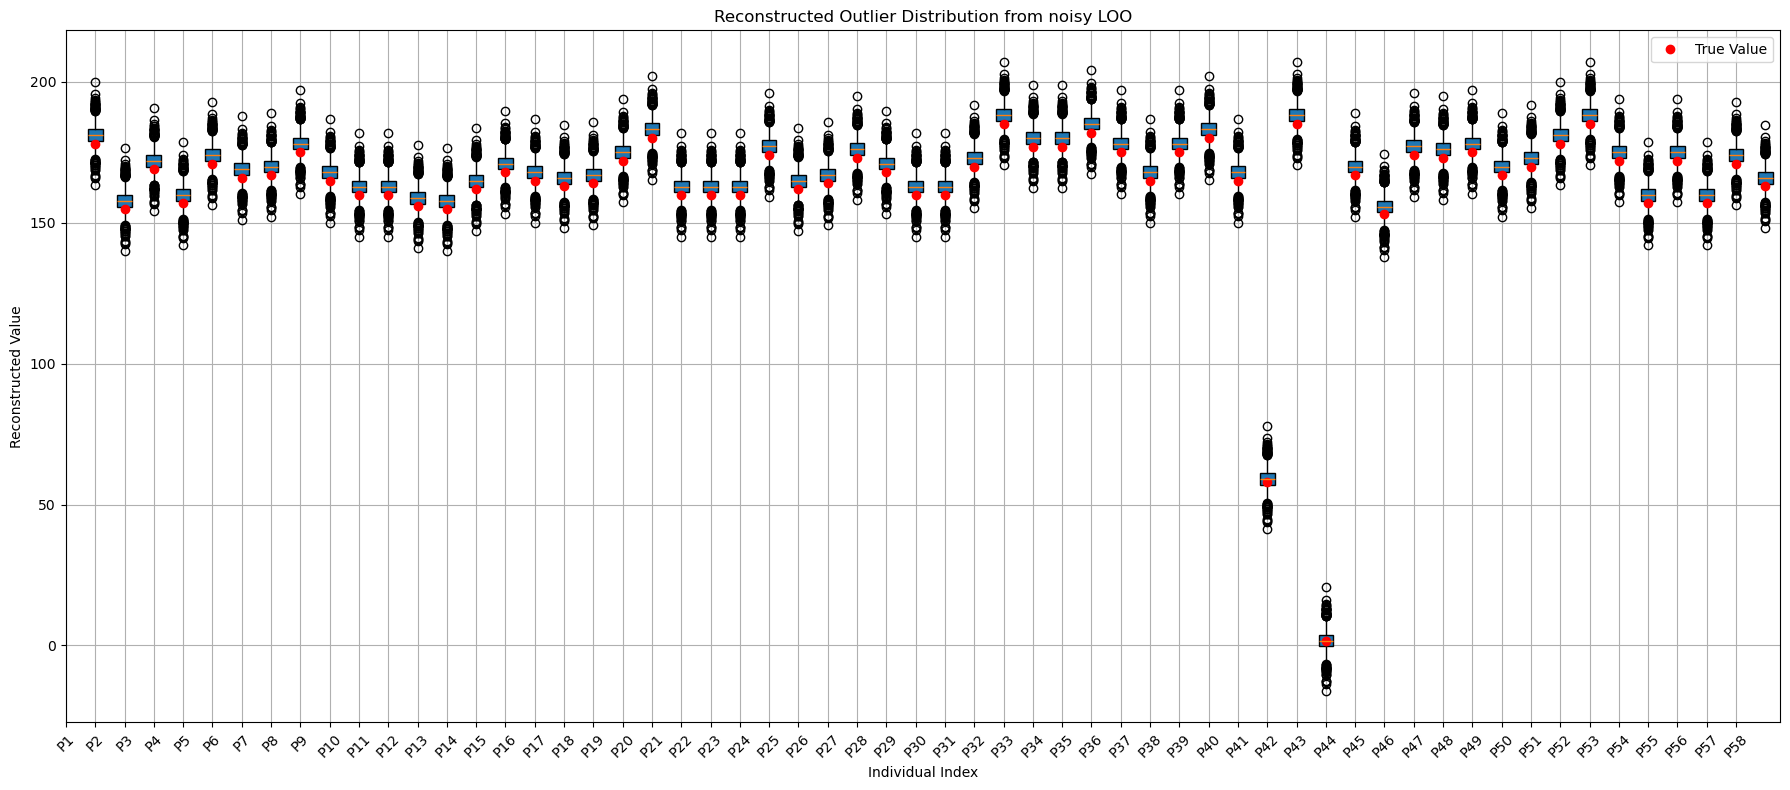

In [95]:
plt.figure(figsize=(18, 8))
plt.boxplot(rec, labels=[f"Person {i+1}" for i in range(n)], patch_artist=True)
plt.plot(range(1, n+1), clean_data, 'ro', label="True Value") 
plt.title("Reconstructed Outlier Distribution from noisy LOO")
plt.xlabel("Individual Index")
plt.xticks(indices, [f"P{i + 1}" for i in indices], rotation=45)
plt.ylabel("Reconstructed Value")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## Interpretation

This plot visually confirms that with proper noise added, for example Laplace via L1 sensitivity, no individual including outlier can be reliably reconstructed, even over 1000 Monte Carlo attempts.

This demonstrates that differential privacy adds enough uncertainty to block attackers from confidently inferring sensitive information, even when they know the structure of the LOO means.